In [1]:
# I/O
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

# Dataset
import numpy as np
import netCDF4 as nc

# Plot
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Time
import time

# Video
from IPython.display import Video

In [2]:
def filename_constructor(time_index, case, var):
    return str(f"/data/cloud2023/vvmData{case}/archive{var}-{str(time_index).zfill(6)}.nc")

casenames = ["/rce_walker_15k_05m_p3",
             "/rce_walker_15k_1m_p3",
             "/rce_walker_1k_1m_p3",
             "/rce_walker_1k_2m_p3"]
varnames = ["/exp.C.LandSurface",
            "/exp.C.Surface",
            "/exp.L.Dynamic",
            "/exp.L.Radiation",
            "/exp.L.Thermodynamic"]
os.getcwd()

'/data/cloud2023/r12229008/HW7'

In [3]:
def intepolate_1d(x):
    return (x[1:] + x[:-1])/2

def temperature_from_theta(theta, pibar):
    return theta*pibar

def saturated_water_vapor_pressure(temperature):
    temp = np.zeros_like(temperature)
    temp[temperature>96] = 6.112*np.exp((17.67*(temperature[temperature>96]-273.15))/(temperature[temperature>96]+243.5-273.15))
    return temp

def saturated_mixing_ratio(pressure, temperature):
    temp = saturated_water_vapor_pressure(temperature)
    return (0.622*temp)/(pressure - temp)

def dry_lapse_rate(pressure, temperature):
    return 9.8076/1003.5

def moist_lapse_rate(pressure, temperature):
    qvs = saturated_mixing_ratio(pressure, temperature)
    Cp_star = (1003.5 + (6.25e12*qvs)/(461.5*temperature**2)) / (1 + (2.5e6*qvs)/(287.05*temperature))
    return 9.8076/Cp_star

def profiler(height, pressure, temperature, mixing_ratio):
    parcel_temperature = np.zeros_like(temperature)
    parcel_mixing_ratio = np.zeros_like(mixing_ratio)
    parcel_lift = np.diff(height, axis = 0)
    parcel_temperature[0] = temperature[0]
    parcel_mixing_ratio[0] = mixing_ratio[0]
    is_saturated = parcel_mixing_ratio[0] >= saturated_mixing_ratio(pressure[0], parcel_temperature[0])
    
    for levels in range(len(pressure)-1):
        parcel_temperature[levels+1][is_saturated] = (parcel_temperature[levels]-moist_lapse_rate(pressure[levels], parcel_temperature[levels]) * parcel_lift[levels])[is_saturated]
        parcel_temperature[levels+1][~is_saturated] = (parcel_temperature[levels]-9.8076/1003.5 * parcel_lift[levels])[~is_saturated]
        temp = saturated_mixing_ratio(pressure[levels+1], temperature[levels+1])
        is_saturated = parcel_mixing_ratio[levels] >= temp
        parcel_mixing_ratio[levels+1][is_saturated] = temp[is_saturated]
        parcel_mixing_ratio[levels+1][~is_saturated] = parcel_mixing_ratio[levels][~is_saturated]
    return parcel_temperature, parcel_mixing_ratio
def separator(lst):
    i,j = 1, 0
    consecutives = [[]]

    while i < len(lst):
        if lst[i-1] == lst[i]-1:
            consecutives[j].append(lst[i-1])
        else:
            consecutives.append([])
            consecutives[j].append(lst[i-1])
            j += 1
        i += 1
    return consecutives

In [24]:
"""
To reach a better understanding about convection, sampled convection area and producce a composite image
Method:
For every single file, and every latitude (or y), choose a snapshot (x-z coordinate), and pick convection area
by rectangle that
center : extreme updraft & downdraft at 3km
length = 48 km
then calculate the mean of these snapshot
"""

# Initialize dataset
case_id = 3
dataset = nc.Dataset(filename_constructor(str(0).zfill(6), casenames[case_id], varnames[2]))
xc = dataset["xc"][:]
yc = dataset["yc"][:]
zc = dataset["zc"][:]

    # composite rectangle
z_index = 13
z_index_len = 35

# rho = np.loadtxt(f"/data/cloud2023/vvmData{casenames[-1]}/fort.98", 
#                  dtype=float,
#                  skiprows=237,
#                  usecols = 1,
#                  unpack=True,
#                  max_rows=46)[:z_index_len]

    # composite data
precipitation = []
buoyancy = []
CAPE = []

# Pressure (hPa)
pressure = np.loadtxt(f"/data/cloud2023/vvmData{casenames[-1]}/fort.98", 
                      dtype=float, 
                      skiprows=237,
                      usecols=3,
                      unpack=True,
                      max_rows=46)[:z_index_len]
pressure = pressure.reshape(-1,1)
pressure /= 100
pressure = np.broadcast_to(pressure, (35,5))

pibar = np.loadtxt(f"/data/cloud2023/vvmData{casenames[-1]}/fort.98", 
                   dtype=float, 
                   skiprows=237,
                   usecols=4,
                   unpack=True,
                   max_rows=46)[:z_index_len]
pibar = pibar.reshape(-1,1)
pibar = np.broadcast_to(pibar, (35,5))
# Step 1.
# Determine convection center by updraft
for time in range(900,1000):
    # current timestep
    print(time)
    # current data
    dataset_Thm = nc.Dataset(filename_constructor(str(time).zfill(6), casenames[case_id], varnames[-1]))
    dataset_Sur = nc.Dataset(filename_constructor(str(time).zfill(6), casenames[case_id], varnames[1]))
    # current vertical velocity
    qr = dataset_Thm["qr"][-1,z_index,:,:]
    centre = np.argmax(qr, axis = 1)
    # For simplicity, check centre is valid
    for y_index in range(len(centre)):
        center = centre[y_index]
        if center < 3 or center > 509:
            pass
        else:
            th = dataset_Thm["th"][-1,:z_index_len,y_index,:]
            qv = dataset_Thm["qv"][-1,:z_index_len,y_index,:]
            thv = th*(1 + 0.608*qv)
            thv -= np.mean(thv, axis = 1).reshape(-1,1)
            buoy = np.trapz(thv[:,center-2:center+3], zc[:z_index_len], axis = 0)
            precip = dataset_Sur.variables["sprec"][-1, y_index, center-2:center+3] * 3600
            
            temperature = temperature_from_theta(th[:,center-2:center+3], pibar)
            
            test = profiler(zc[:z_index_len], pressure, temperature, qv[:,center-2:center+3])
            cape = np.zeros((5,))
            for i in range(5):
                de = test[0][:,i]-temperature[:,i]
                el = np.argwhere(de>0).flatten()
                if el.size <= 1:
                    cape[i] = 0
                else:
                    
                    el = separator(el.tolist())
                    lfc = el[0][0]
                    el = el[0][-1]
                    
                    cape[i] = -np.trapz(test[0][lfc:el,i]-temperature[lfc:el,i], np.log(pressure[lfc:el,i]))*287.05
                    
            for i in range(5):
                precipitation.append(precip[i])
                buoyancy.append(buoy[i])
                CAPE.append(cape[i])

900


/tmp/ipykernel_124641/4063147614.py:92: UserWarning: Warning: converting a masked element to nan.
  cape[i] = -np.trapz(test[0][lfc:el,i]-temperature[lfc:el,i], np.log(pressure[lfc:el,i]))*287.05


901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999


In [25]:
buoyancy = [x / 1004 for x in buoyancy]

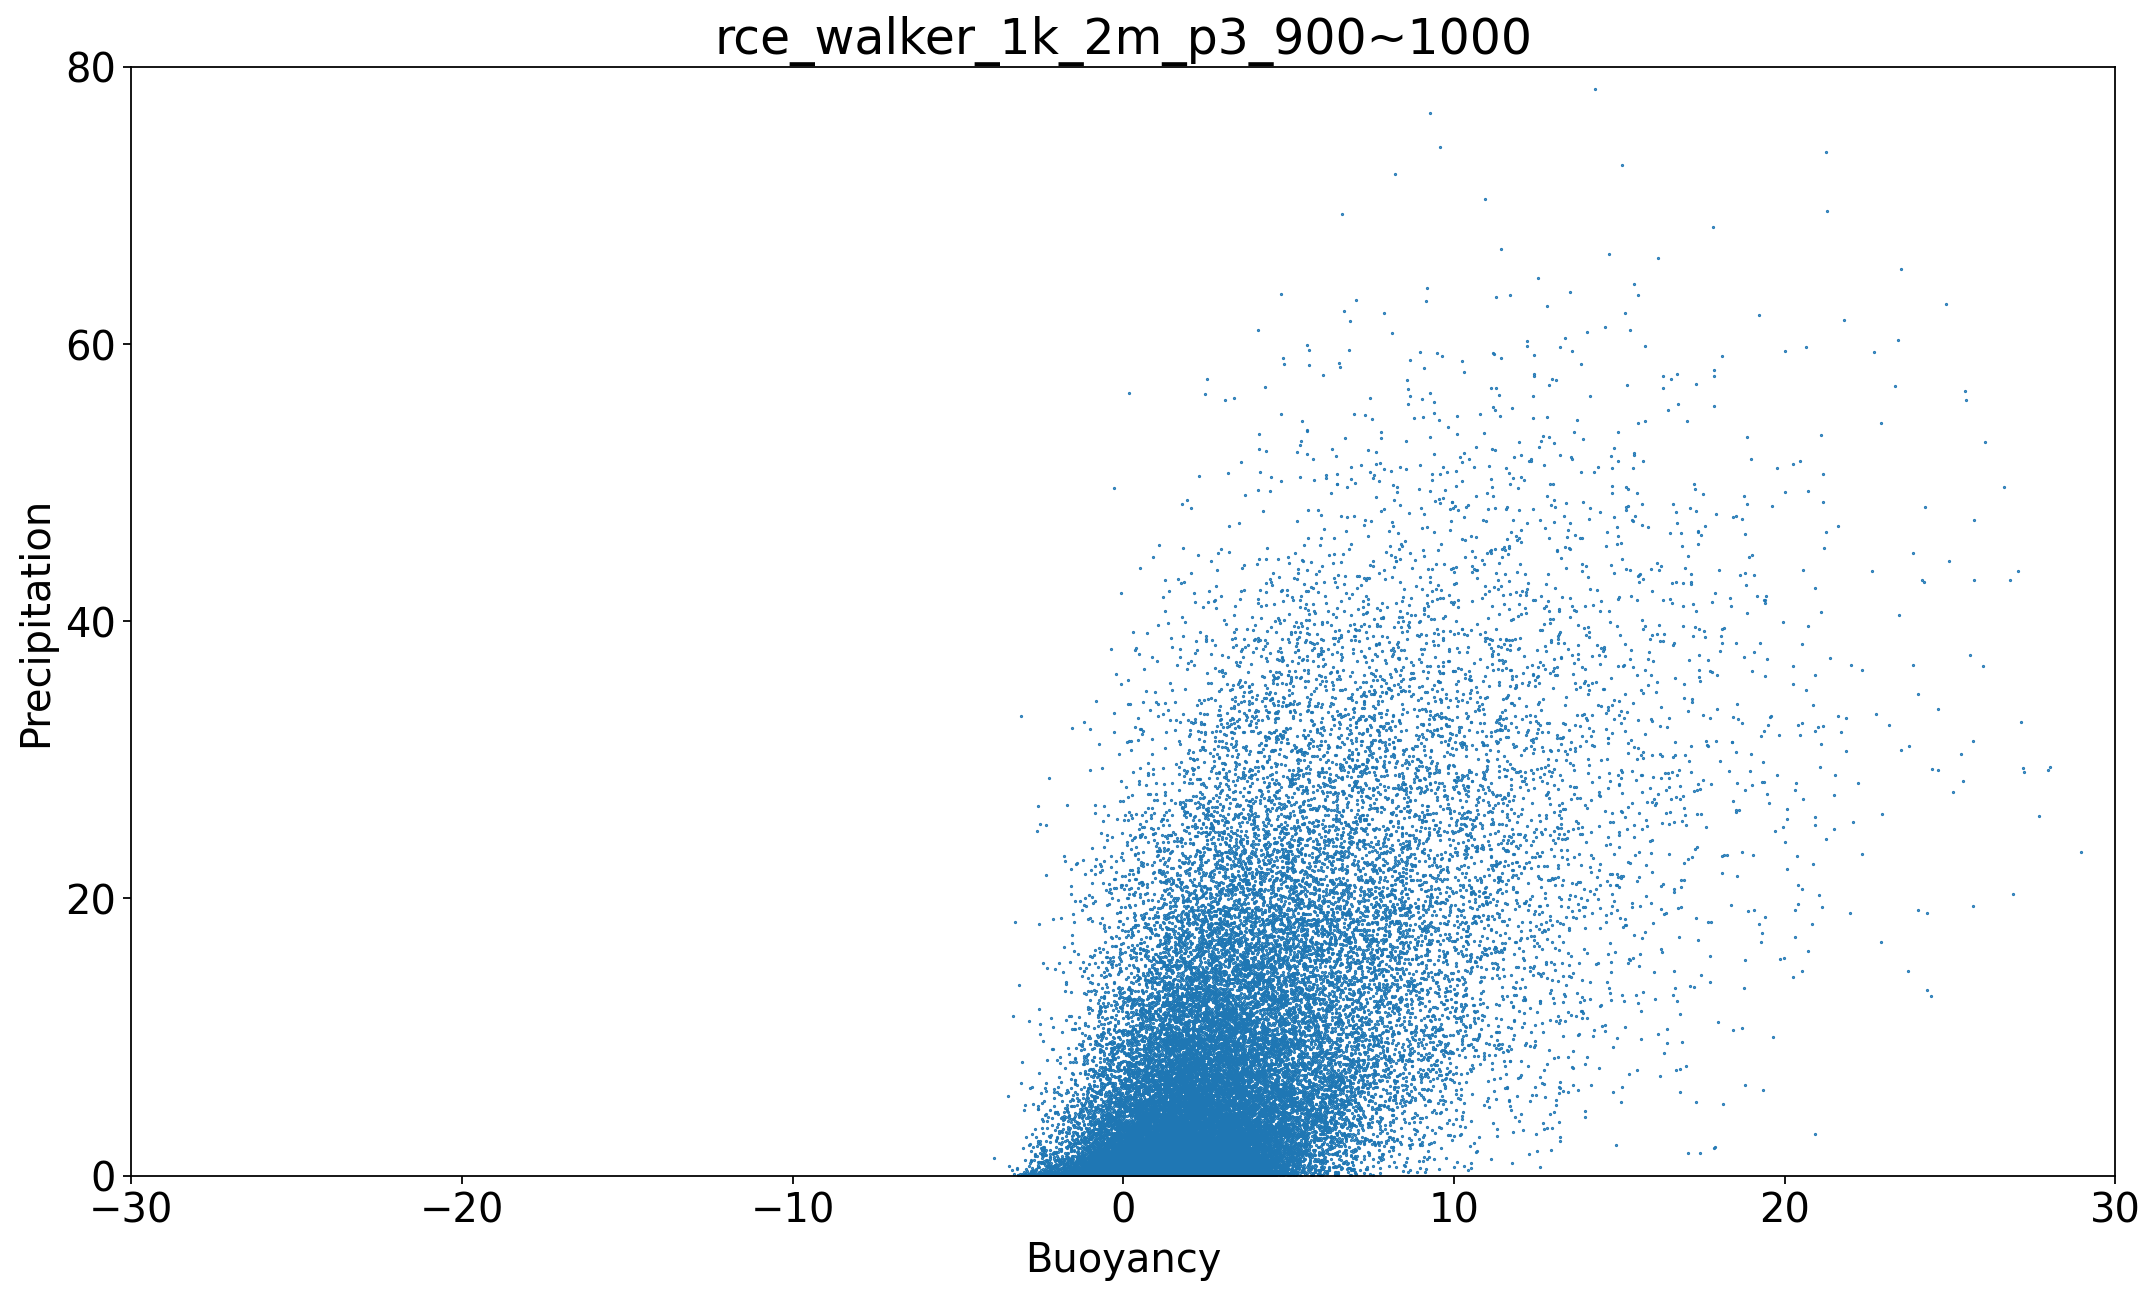

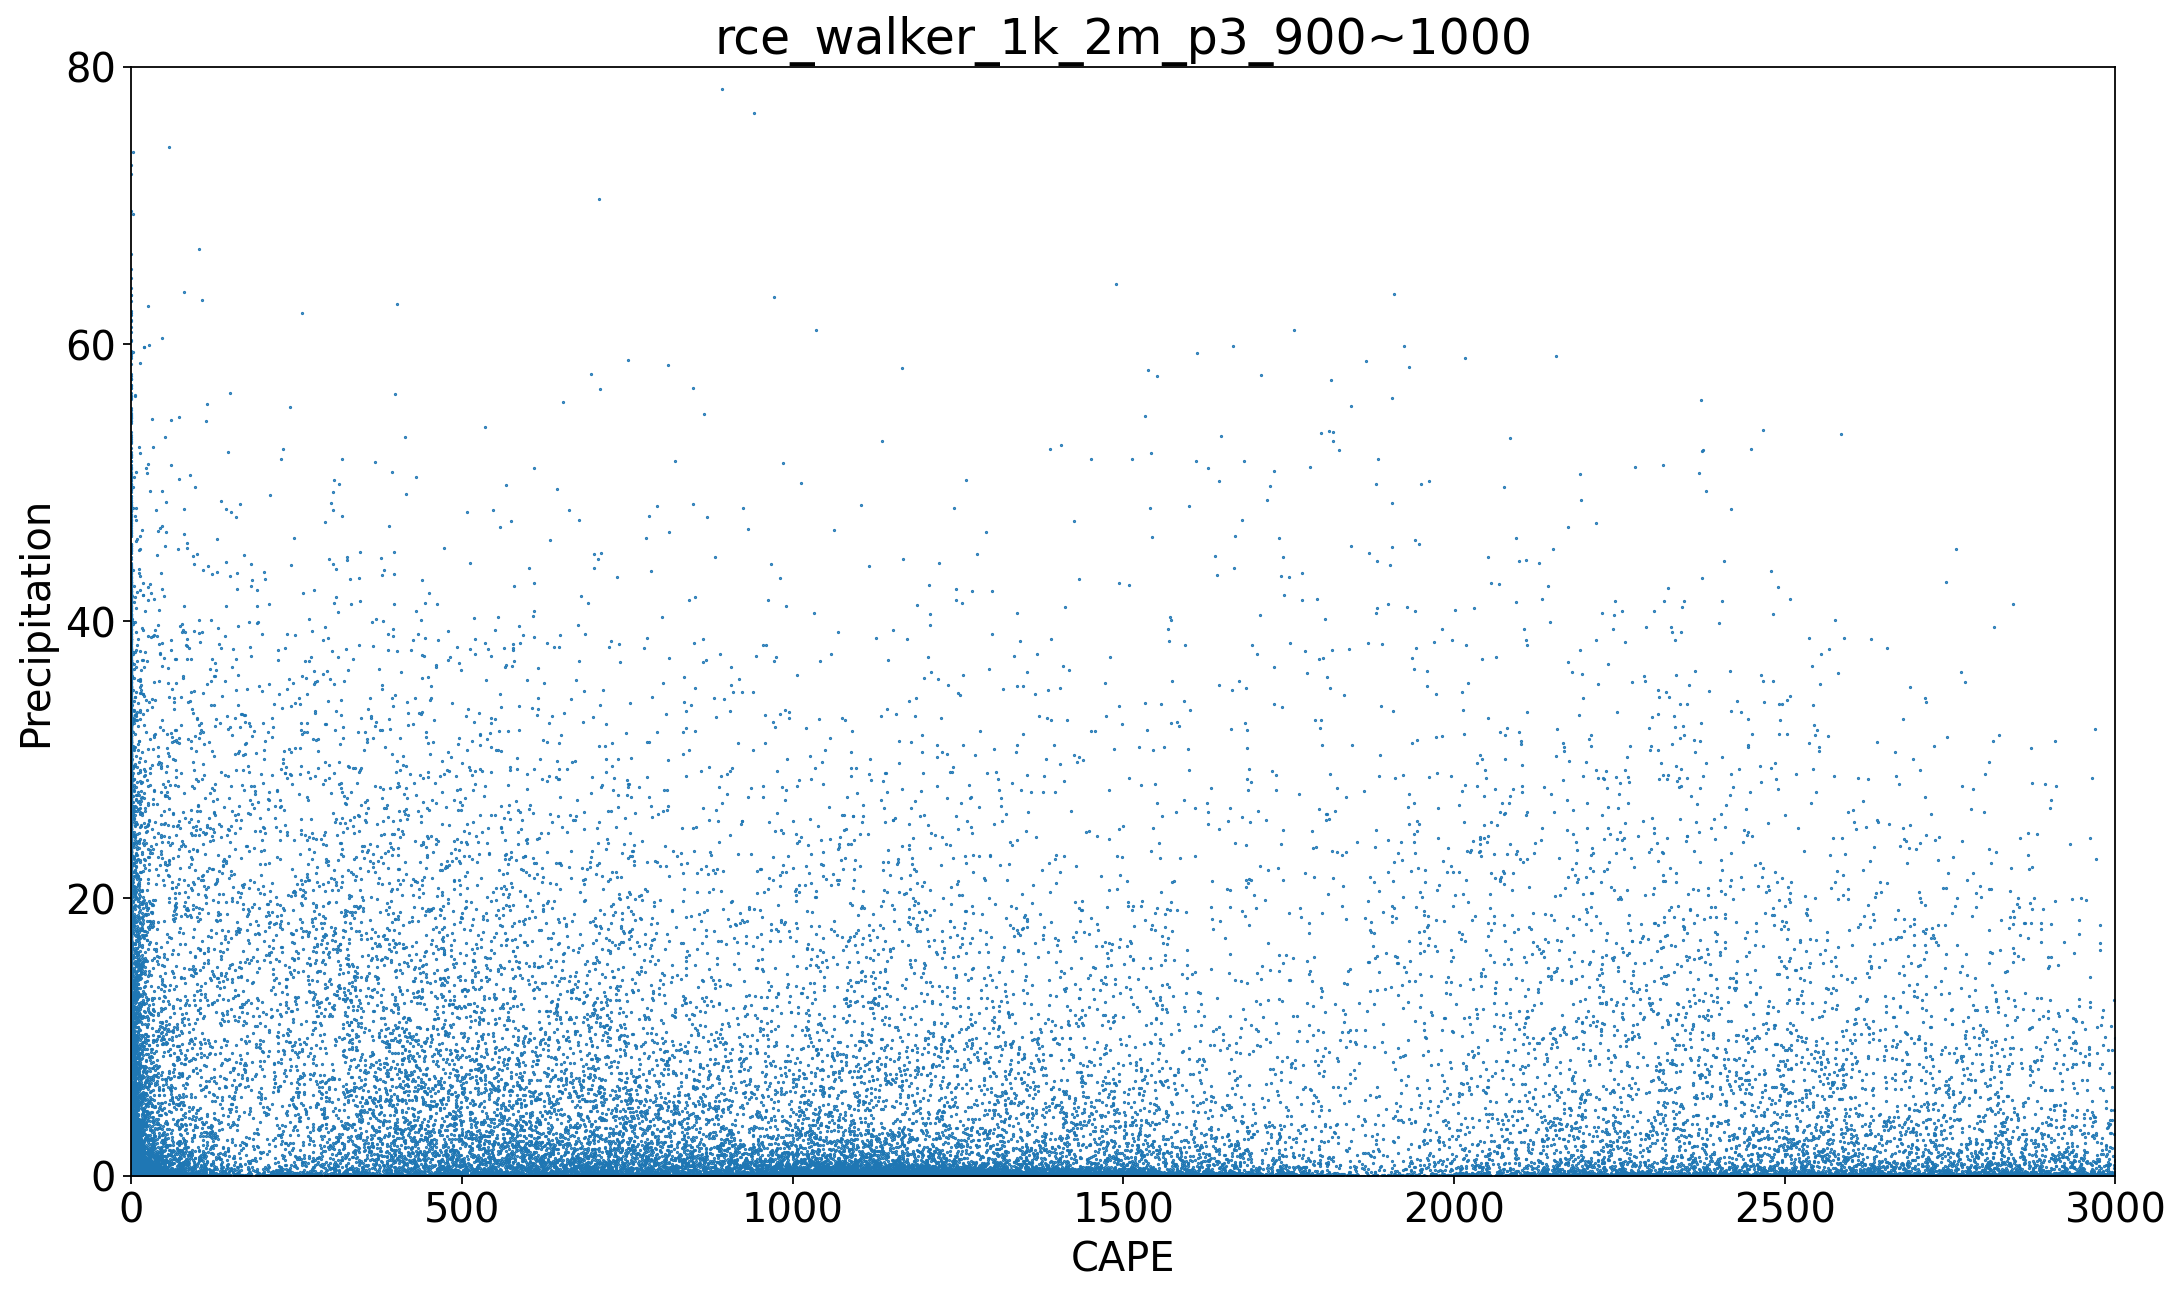

In [26]:
plt.figure(figsize = (16,9), dpi = 160)
plt.scatter(buoyancy, precipitation, s = 0.2)
plt.xlabel("Buoyancy", fontsize = 18)
plt.xticks(np.linspace(-30, 30,7), fontsize = 18)
plt.xlim(-30, 30)
plt.ylabel("Precipitation", fontsize = 18)
plt.yticks(np.linspace(0, 80,5), fontsize = 18)
plt.ylim(0, 80)
plt.title(f"{casenames[case_id][1:]}_900~1000", fontsize = 22)
plt.savefig(f"{casenames[case_id][1:]}_PB_900~1000.png")
plt.figure(figsize = (16,9), dpi = 160)
plt.scatter(CAPE, precipitation, s = 0.2)
plt.xlabel("CAPE", fontsize = 18)
plt.xticks(np.linspace(0, 3000, 7), fontsize = 18)
plt.xlim(0, 3000)
plt.ylabel("Precipitation", fontsize = 18)
plt.yticks(np.linspace(0, 80,5), fontsize = 18)
plt.ylim(0, 80)
plt.title(f"{casenames[case_id][1:]}_900~1000", fontsize = 22)
plt.savefig(f"{casenames[case_id][1:]}_PC_900~1000.png")